In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [2]:
df = pd.read_csv("sp500.csv")

In [3]:
df['entries'] = np.vectorize(lambda sefi, adr: 1 if (sefi or adr) else 0)(df['SEFI Signal Long'], df['ADR Signal Long'])

In [4]:
def get_highest_correlations_labels(df: pd.DataFrame, colname: str, n: int = 3) -> list:
    return list(pd.Series(np.vectorize(lambda x: abs(x) if not x == 1 else np.nan)(df.corr().loc[colname]),
                     index=df.corr().loc[colname].index).sort_values(ascending=False).iloc[:n].index)


def adjust_dataframe_ratio(df: pd.DataFrame, colname: str, ideal_ratio: float = 0.25 ):
    counts = df[colname].value_counts()
    if counts.loc[0] > counts.loc[1]:
        if counts.loc[0] * ideal_ratio - counts.loc[1] > 0:
            diff = int(counts.loc[0] * ideal_ratio - counts.loc[1])
        else:
            diff = counts.loc[0] - counts.loc[1]
        to_drop = df[df['entries'] == 0].sample(frac=1)
        df.drop(to_drop.iloc[:diff].index, inplace=True)

In [5]:
df.index = df['Date']
df.drop(["Date" ,"Ticker", "Close", "Change", "Volume_Change", "SEFI Signal Long", "SEFI Signal Short", "ADR Signal Long", "ADR Signal Short", "ADR", "SEFI"], axis=1, inplace=True)

adjust_dataframe_ratio(df, colname="entries", ideal_ratio=1)

In [6]:
X = pd.get_dummies(df[["STOCH_K", "STOCH_D", "MACD_histogram", "RSI"]], drop_first=True)
y= df['entries']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.linspace(50, 170, 20, dtype="int32")
max_features = [2, 3, 4]
bootstrap = [True, False]
oob_score = [True, False]

param_grid = {"n_estimators": n_estimators, "max_features": max_features, "bootstrap": bootstrap, "oob_score": oob_score}

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, param_grid)
grid.fit(X_train, y_train)

/home/rickturner/Projects/screener/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rickturner/Projects/screener/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rickturner/Projects/screener/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 437, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': array([ 50,  56,  62,  68,  75,  81,  87,  94, 100, 106, 113, 119, 125,
       132, 138, 144, 151, 157, 163, 170], dtype=int32),
                         'oob_score': [True, False]})

In [34]:
grid.best_params_

{'bootstrap': False,
 'max_features': 2,
 'n_estimators': 138,
 'oob_score': False}

In [29]:
rfc = RandomForestClassifier(max_features=3, n_estimators=138, oob_score=True, bootstrap=True)

In [30]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=138, oob_score=True)

In [31]:
rfc.oob_score_

0.9117117117117117

In [32]:
predictions = rfc.predict(X_test)

/home/rickturner/Projects/screener/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


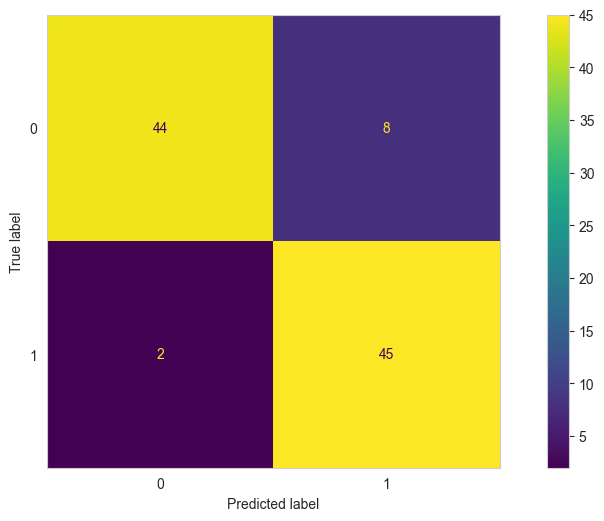

In [33]:
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

fig,ax = plt.subplots(figsize=(12,6), dpi=100)
ax.grid(False)
plot_confusion_matrix(rfc, X_test, y_test, ax=ax)

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90        52
           1       0.85      0.96      0.90        47

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.91      0.90      0.90        99



In [37]:
errors = []
misclassifications = []

for n in range(1, 500):

    rfc = RandomForestClassifier(n_estimators=n, max_features=3)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    err =  1 - accuracy_score(y_test, preds)
    n_missed = np.sum(preds != y_test)

    errors.append(err)
    misclassifications.append(n_missed)


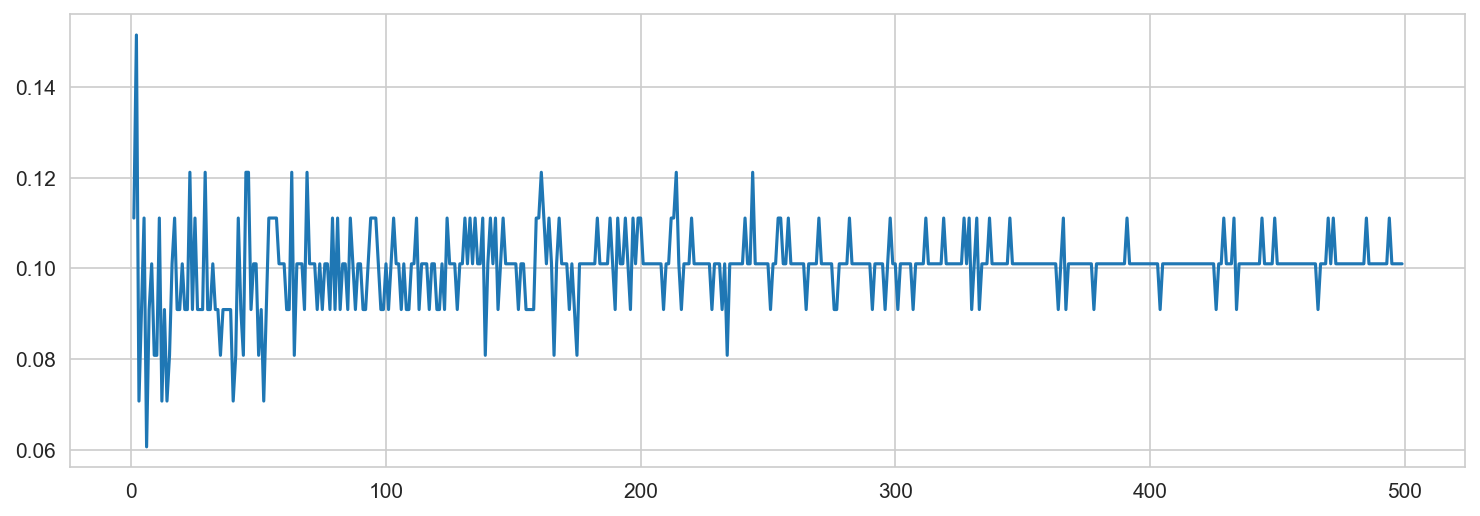

In [39]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(range(1, 500), errors)

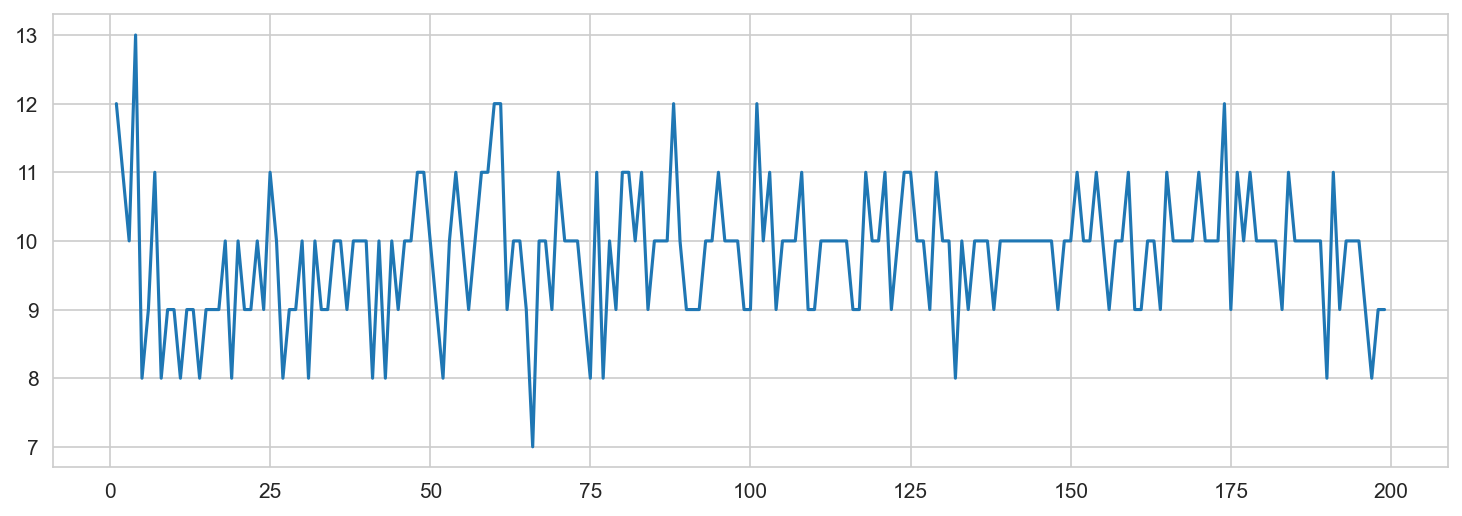

In [22]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(range(1, 200), misclassifications)

Date
2016-05-02    0
2016-01-21    1
2022-05-10    1
2018-07-16    0
2019-05-22    0
             ..
2016-10-28    0
2020-01-14    0
2021-02-01    1
2020-03-24    1
2015-12-01    0
Name: entries, Length: 99, dtype: int64